In [33]:
import wandb

In [34]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [35]:
wandb.init(project="lorenz_lstm", group="Lorenz",save_code=True,notes="Lorenz LSTM run and evaluation")

In [36]:
from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import seaborn as sns

In [37]:
def visualize(real=None, train=None, save=None, title=''):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    
    ax.set_title('Lorenz Attractor \n'+title)

    if train is not None:
      sns.set(style='darkgrid')
      
      z = np.array([o.detach().numpy() for o in train])
      z = np.reshape(z, [-1,3])
      sc = ax.scatter(z[:,0], z[:,1], z[:,2], c=z[:,2], cmap='Greens', s=1)
      #cbar = fig.colorbar(sc)

    if real is not None:
      #sns.set(style='darkgrid')
      
      z = np.array([o.detach().numpy() for o in real])
      z = np.reshape(z, [-1,3])
      ax.scatter(z[:,0], z[:,1], z[:,2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)
      #sc = ax.scatter(z[:,0], z[:,1], z[:,2], c=z[:,2], cmap='Reds', s=1)
      #cbar = fig.colorbar(sc)
      #ax.scatter(, marker='.', c=c,cmap='viridis', alpha=0.5, linewidths=0, s=45)

    fig.canvas.draw()
    fig.canvas.flush_events()
    if save is not None:
        plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
    plt.show()

In [38]:
class Lorenz(nn.Module):
    """
    chaotic lorenz system
    """
    def __init__(self):
        super(Lorenz, self).__init__()
        self.lin = nn.Linear(5, 3, bias=False)
        W = torch.tensor([[-10., 10., 0., 0., 0.],
                          [28., -1., 0., -1., 0.],
                          [0., 0., -8. / 3., 0., 1.]])
        self.lin.weight = nn.Parameter(W)

    def forward(self, t, x):
        y = y = torch.ones([1, 5])
        y[0][0] = x[0][0]
        y[0][1] = x[0][1]
        y[0][2] = x[0][2]
        y[0][3] = x[0][0] * x[0][2]
        y[0][4] = x[0][0] * x[0][1]
        return self.lin(y)

true_y0 = torch.tensor([[1., 0., 0.]])  # initial condition
t = torch.linspace(0., 50., 5000)  # t is from 0 to 25 for 1000 data points

# generating training data
with torch.no_grad():
    data = odeint(Lorenz(), true_y0, t)



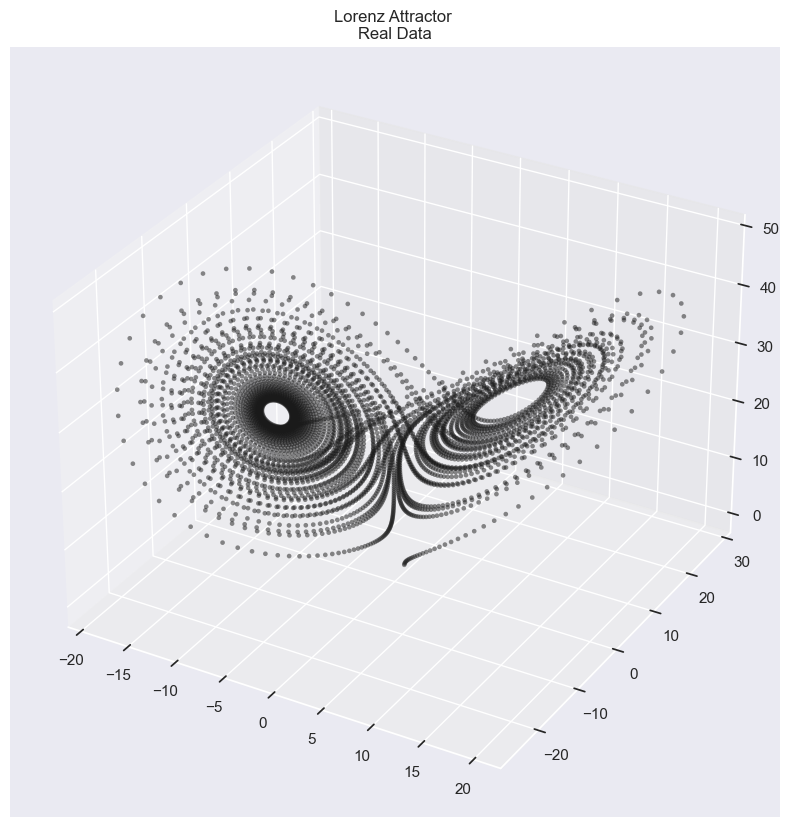

In [39]:
visualize(real=data,save='real',title='Real Data')

In [40]:
torch.manual_seed(7) # Set the random seed
np.random.seed(7) # Set the random seed

In [41]:
# Define the number of random starting points (N)
N = 10  # You can change this to your desired value

# Generate random starting points using NumPy
x0_np = -15 + 30 * np.random.random((N, 3))

# Convert the NumPy array to a PyTorch tensor
x0_tensor = torch.tensor(x0_np, dtype=torch.float32)

In [42]:
x0_tensor

tensor([[-1.2711e+01,  8.3976e+00, -1.8477e+00],
        [ 6.7040e+00,  1.4340e+01,  1.1549e+00],
        [ 3.3614e-02, -1.2838e+01, -6.9468e+00],
        [-3.5250e-03,  5.3769e+00,  9.1122e+00],
        [-3.5718e+00, -1.3022e+01, -6.3556e+00],
        [ 1.2288e+01, -8.5984e+00, -1.4363e+00],
        [ 1.2936e+01, -1.4253e+01,  3.0165e+00],
        [ 1.3504e+01, -8.0909e+00,  1.4547e+00],
        [ 1.2274e+01, -1.1005e+01,  7.0238e-01],
        [ 7.5123e+00,  5.0704e+00, -9.6741e-01]])

In [43]:
# data_list = []
# #num_conditions = 10
# # Generate data for each initial condition and stack them into a single tensor
# conditions = x0_tensor
# for _ in conditions:
#     true_y0 = _  # Random initial condition as a torch tensor
#     t = torch.linspace(0., 50., 5000)  # t is from 0 to 10 for 5000 data points

#     # Generate data for the current initial condition
#     with torch.no_grad():
#         data = odeint(Lorenz(), true_y0.unsqueeze(0), t)  # Unsqueezing to add batch dimension

#     # Append the generated data to the list
#     data_list.append(data)

# # Stack the data tensors along a new dimension to create a single tensor
# data_tensor = torch.stack(data_list)

In [44]:
# torch.save(data_tensor, 'data_tensor.pt')

In [45]:
data_tensor = torch.load('data_tensor.pt')

In [46]:
data_tensor.shape

torch.Size([10, 5000, 1, 3])

In [47]:
train = data_tensor[:6]
val = data_tensor[6]
test = data_tensor[7:]

In [48]:
train = train.view(30000,1,3)

In [49]:
train.shape

torch.Size([30000, 1, 3])

In [50]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)

        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Reshape output for the fully connected layer
        #out = out[:, -1, :]

        # Fully connected layer
        out = self.fc(out)

        return out

# Define input size, hidden size, and output size
input_size = 3
hidden_size = 512
output_size = 3

# Create an instance of the LSTMModel
model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())



In [51]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.stack(X).squeeze(2), torch.stack(y).squeeze(1).squeeze(2)
 
lookback = 30
X_train, y_train = create_dataset(train, lookback=lookback)

In [52]:
y_train.shape

torch.Size([29970, 30, 3])

In [53]:
X_train.shape

torch.Size([29970, 30, 3])

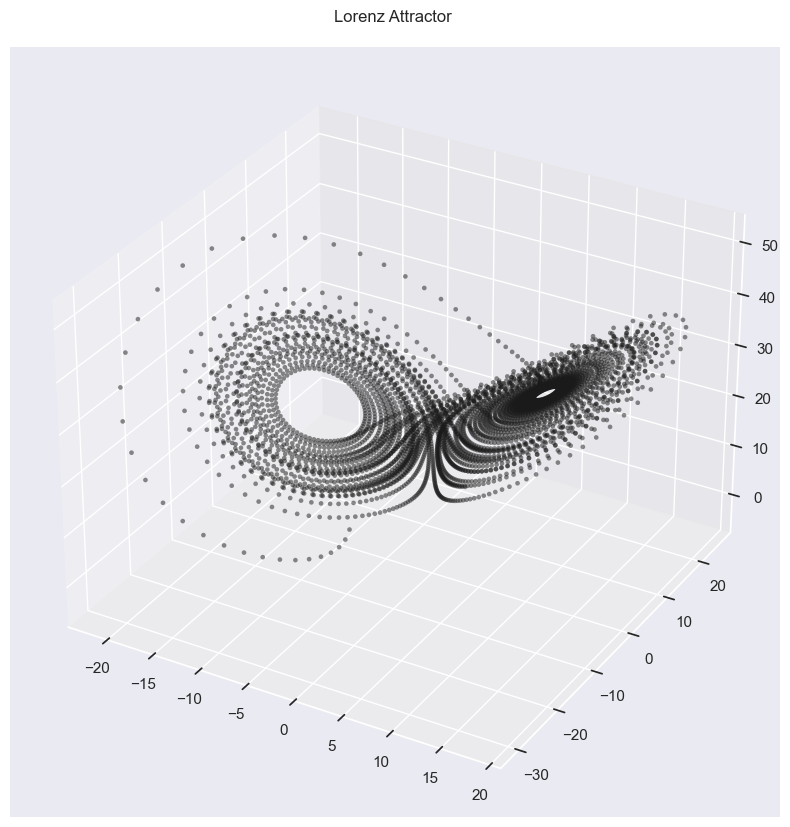

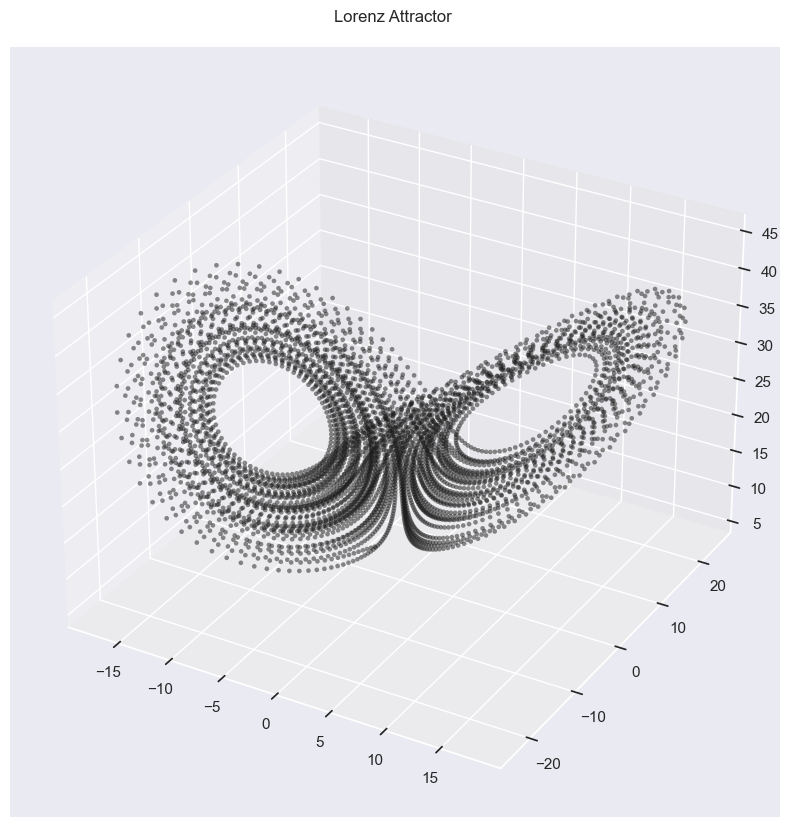

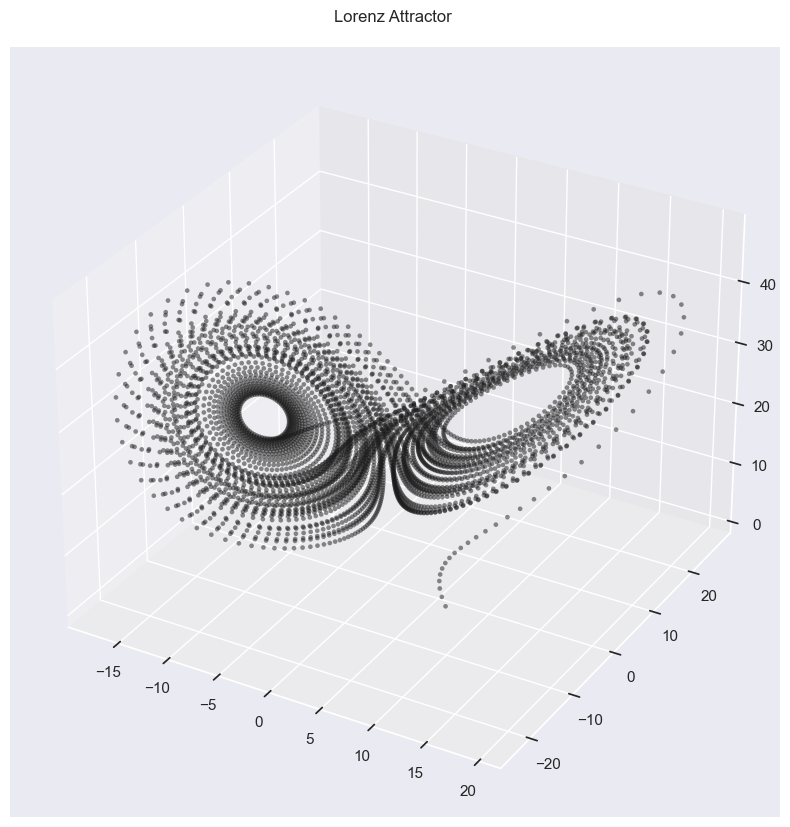

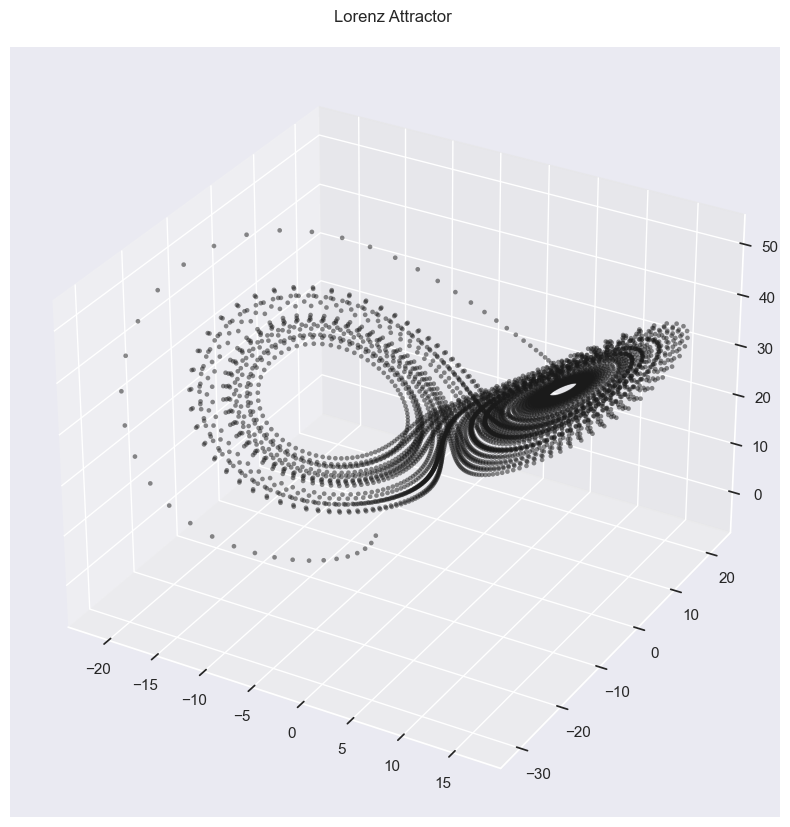

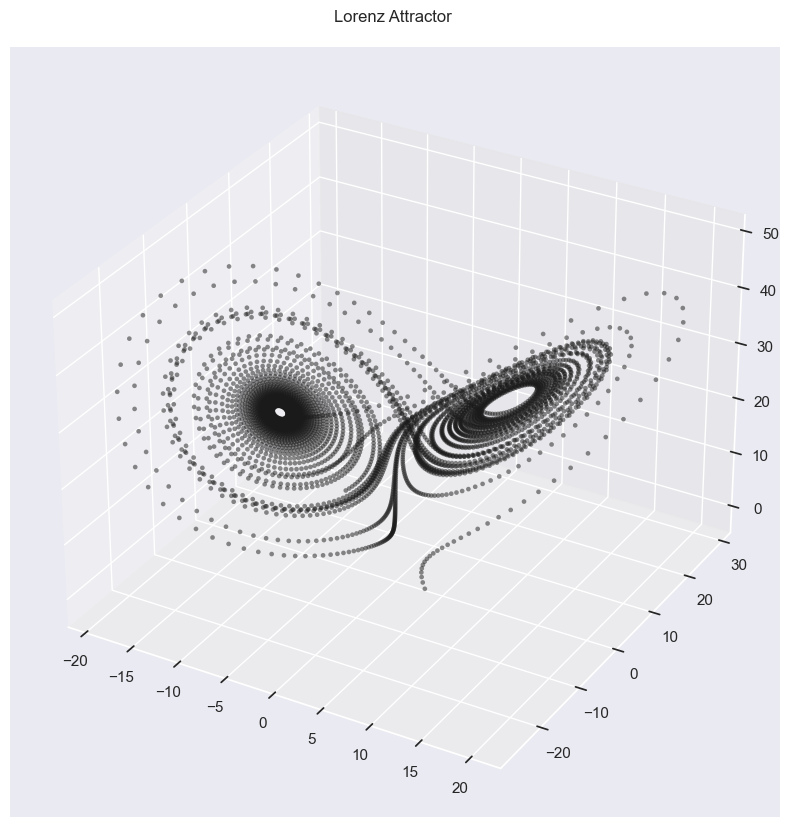

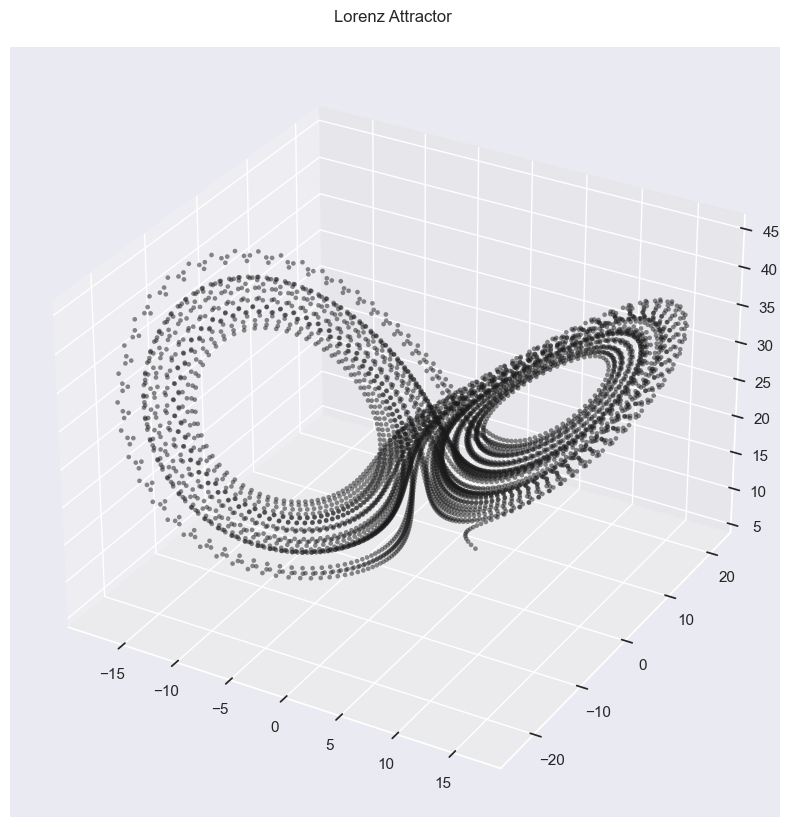

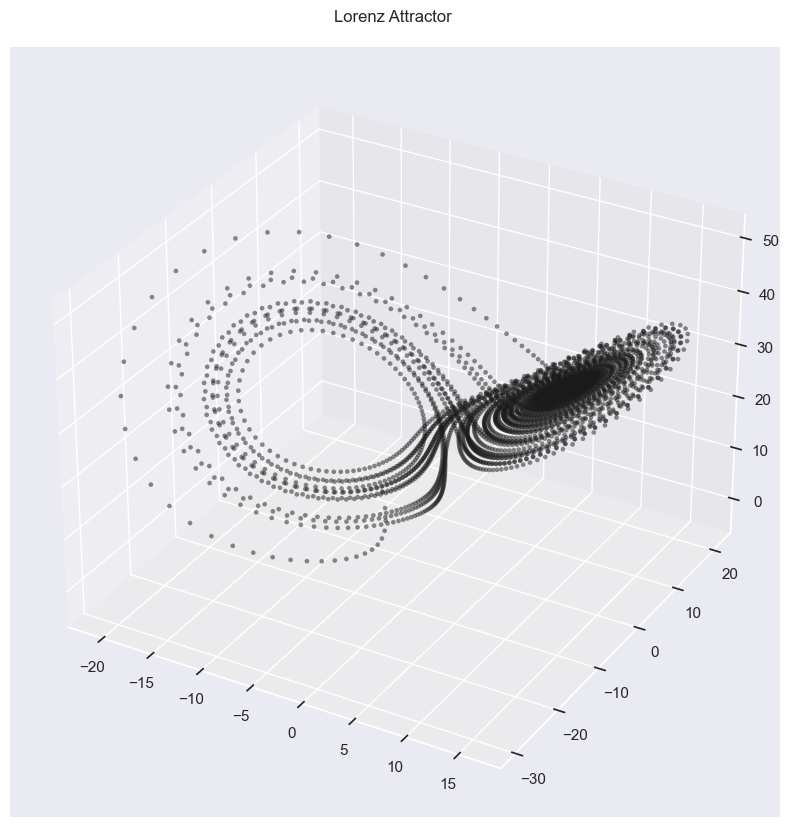

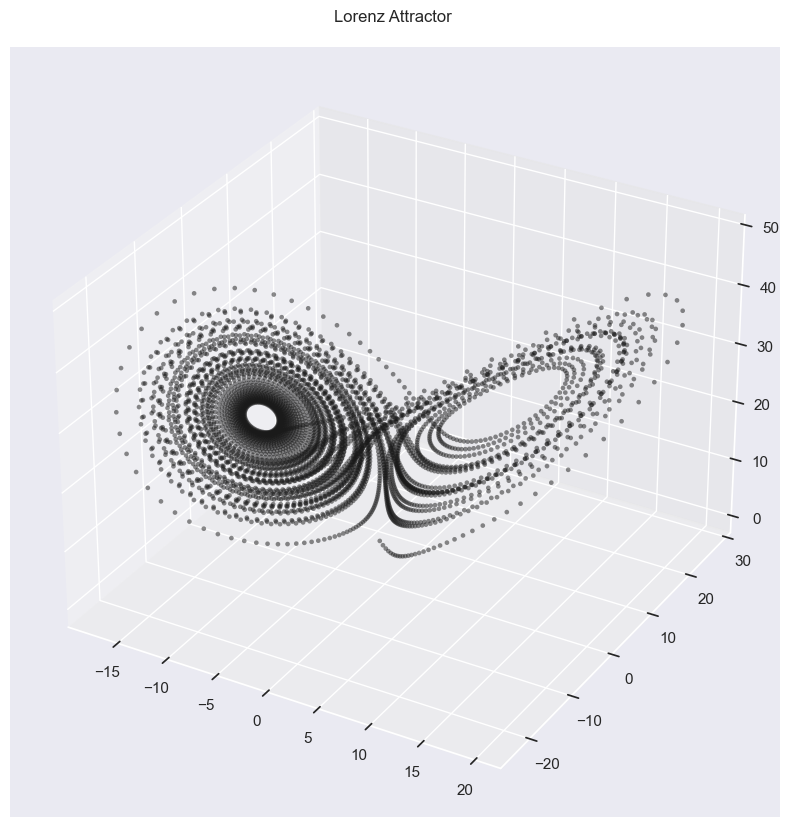

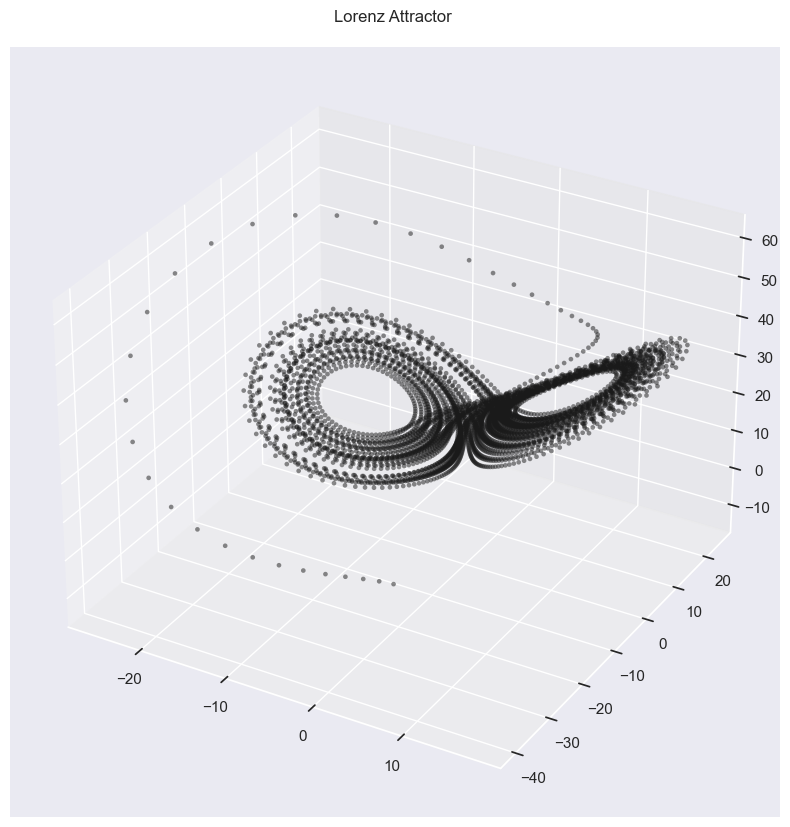

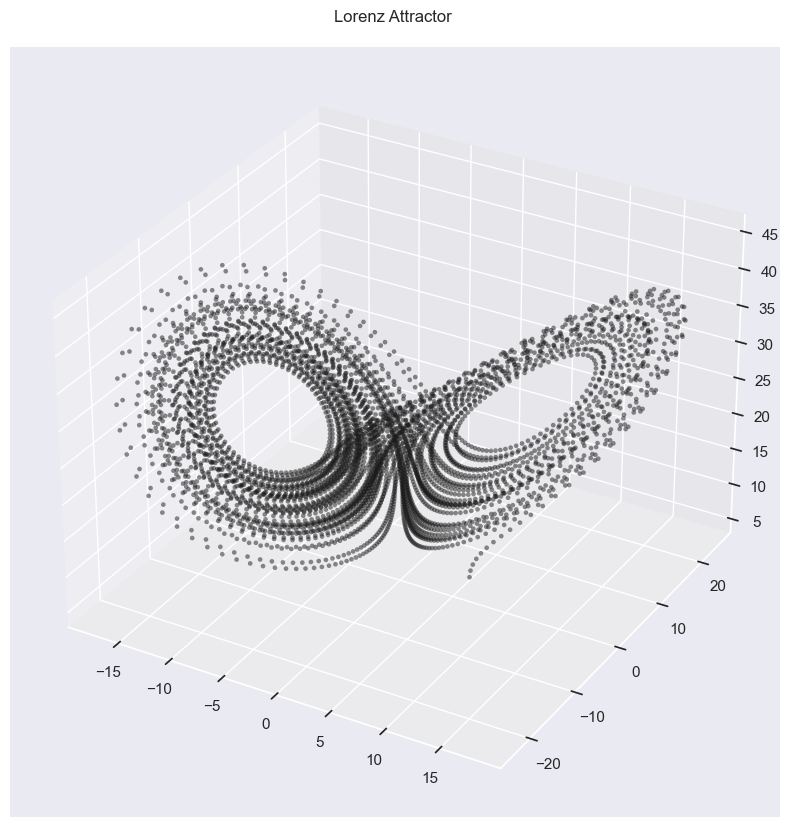

In [54]:
for i in range(len(data_tensor)):
  visualize(real=data_tensor[i])

In [55]:
import torch.utils.data as lon

In [56]:
loader = lon.DataLoader(lon.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)

In [57]:
x_val, y_val = create_dataset(val, lookback=lookback)

In [58]:
val_loader = lon.DataLoader(lon.TensorDataset(x_val, y_val), shuffle=False, batch_size=8)

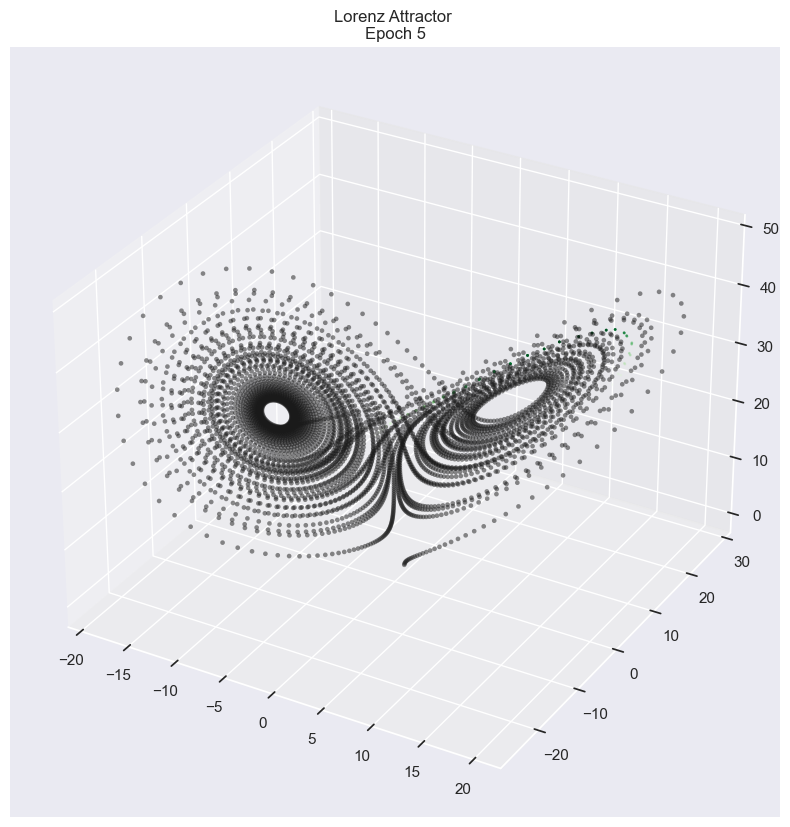

Epoch [6/10], Loss: 0.2120


In [59]:
val_losses = []
epoch_losses = []
num_epochs = 10
for epoch in range(num_epochs):
    batch_losses = []
    for x,y in loader:
        optimizer.zero_grad()
        # Forward pass
        predicted_lorenz = model(x)

        # Compute the loss
        loss = criterion(predicted_lorenz, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    epoch_losses.append(np.mean(batch_losses))
    
    if epoch % 5 == 0:
        
        with torch.no_grad():
            val_batch_loss = []
            for x,y in loader:
                
                # Forward pass
                predicted_lorenz = model(x)

                # Compute the loss
                loss = criterion(predicted_lorenz, y)
                val_batch_loss.append(loss.item())
            val_losses.append(np.mean(val_batch_loss))
            visualize(real=data, 
                                train=predicted_lorenz,save='PNG/LSTM/{}'.format(epoch),title='Epoch {}'.format(epoch))
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            clear_output(wait=True)


In [116]:
x_test, y_test = create_dataset(test[0], lookback=1)

In [137]:
test_loader = lon.DataLoader(lon.TensorDataset(x_test, y_test), shuffle=False, batch_size=1)

In [138]:
test_losses = []
predictions = []
with torch.no_grad():
            preds = []
            test_batch_loss = []
            for x,y in test_loader:
                
                # Forward pass
                predicted_lorenz = model(x)
                preds.append(predicted_lorenz)
                # Compute the loss
                loss = criterion(predicted_lorenz, y)
                test_batch_loss.append(loss.item())
            predictions = torch.stack(preds)
            test_losses.append(np.mean(val_batch_loss))

In [139]:
predictions.shape

torch.Size([4999, 1, 1, 3])

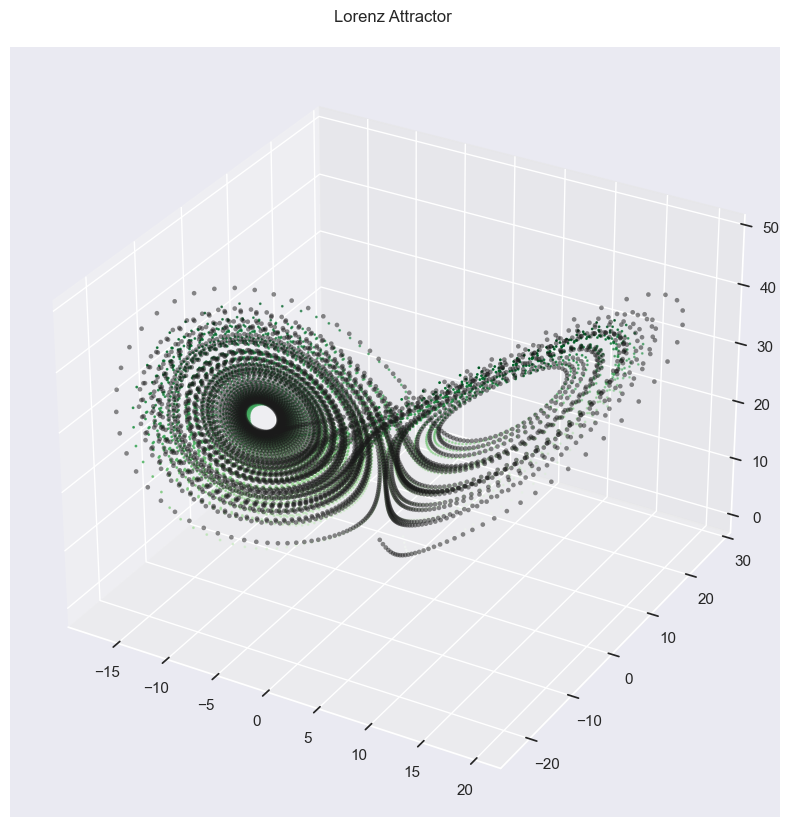

In [140]:
visualize(train=predictions,real=test[0])

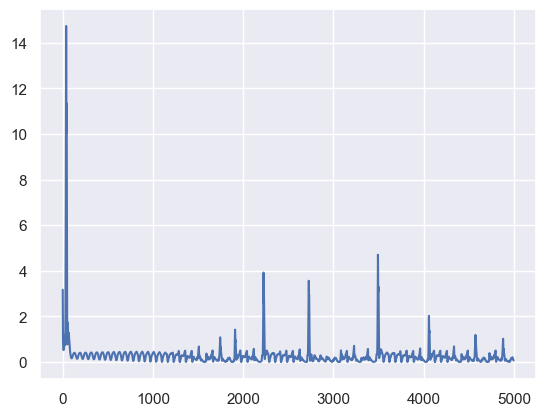

In [141]:
plt.plot(test_batch_loss)
plt.show()

In [123]:
test[0].shape

torch.Size([5000, 1, 3])

In [124]:
predictions.shape

torch.Size([4999, 1, 1, 3])

In [142]:
x_pred = predictions[:,:,:, 0]
y_pred = predictions[:,:, :,1]
z_pred = predictions[:, :,:,2]

In [143]:
x_train = test[0][:, :, 0]
y_train = test[0][:, :, 1]
z_train = test[0][:, :, 2]

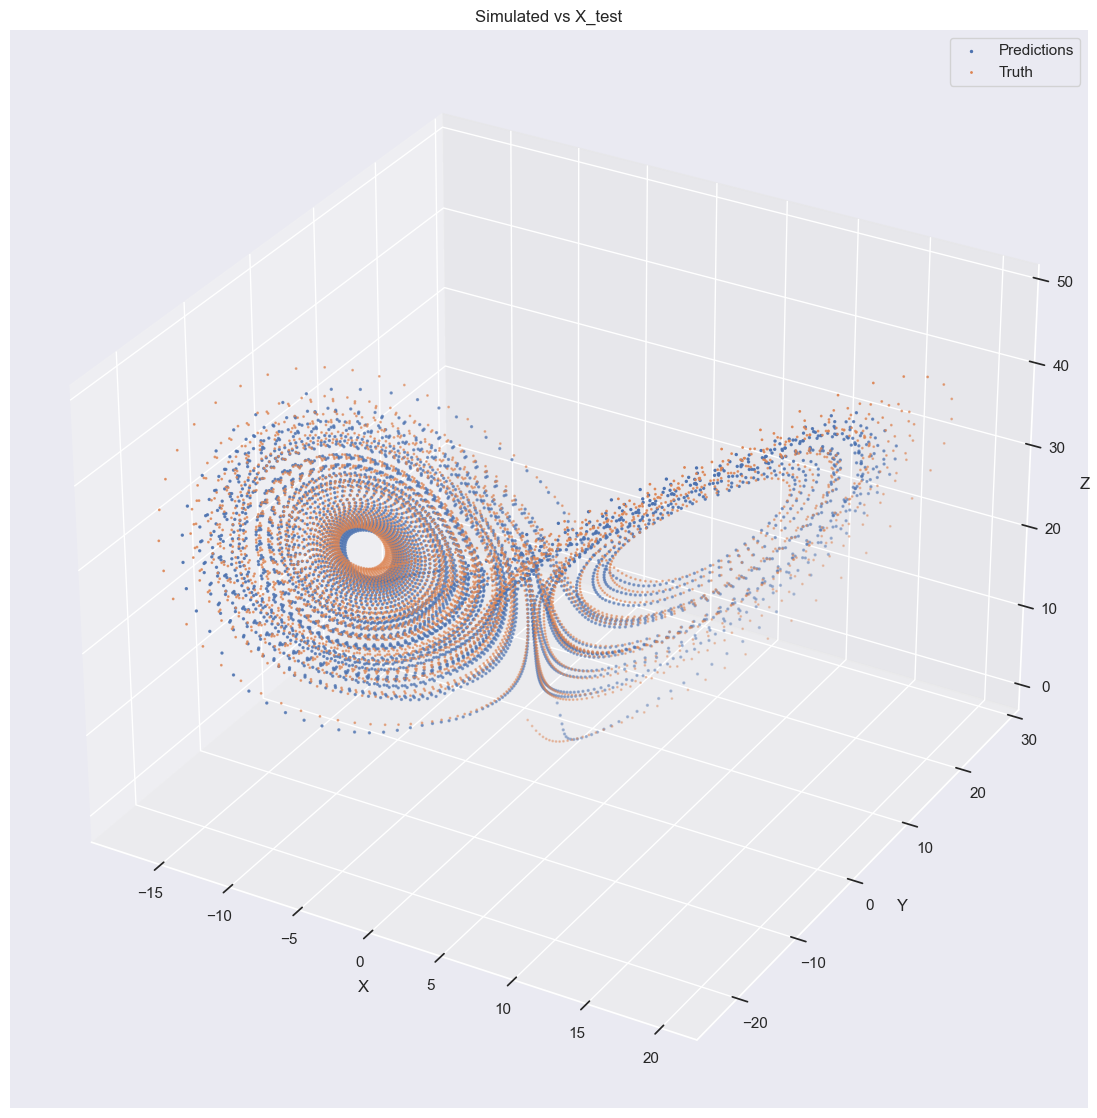

In [148]:
# Create a 3D plot
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pred, y_pred, z_pred, label='Predictions',s=2)
ax.scatter(x_train, y_train, z_train, label='Truth',s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simulated vs X_test')
ax.legend()

# Show the plot
plt.show()

In [149]:
x_train.shape

torch.Size([5000, 1])

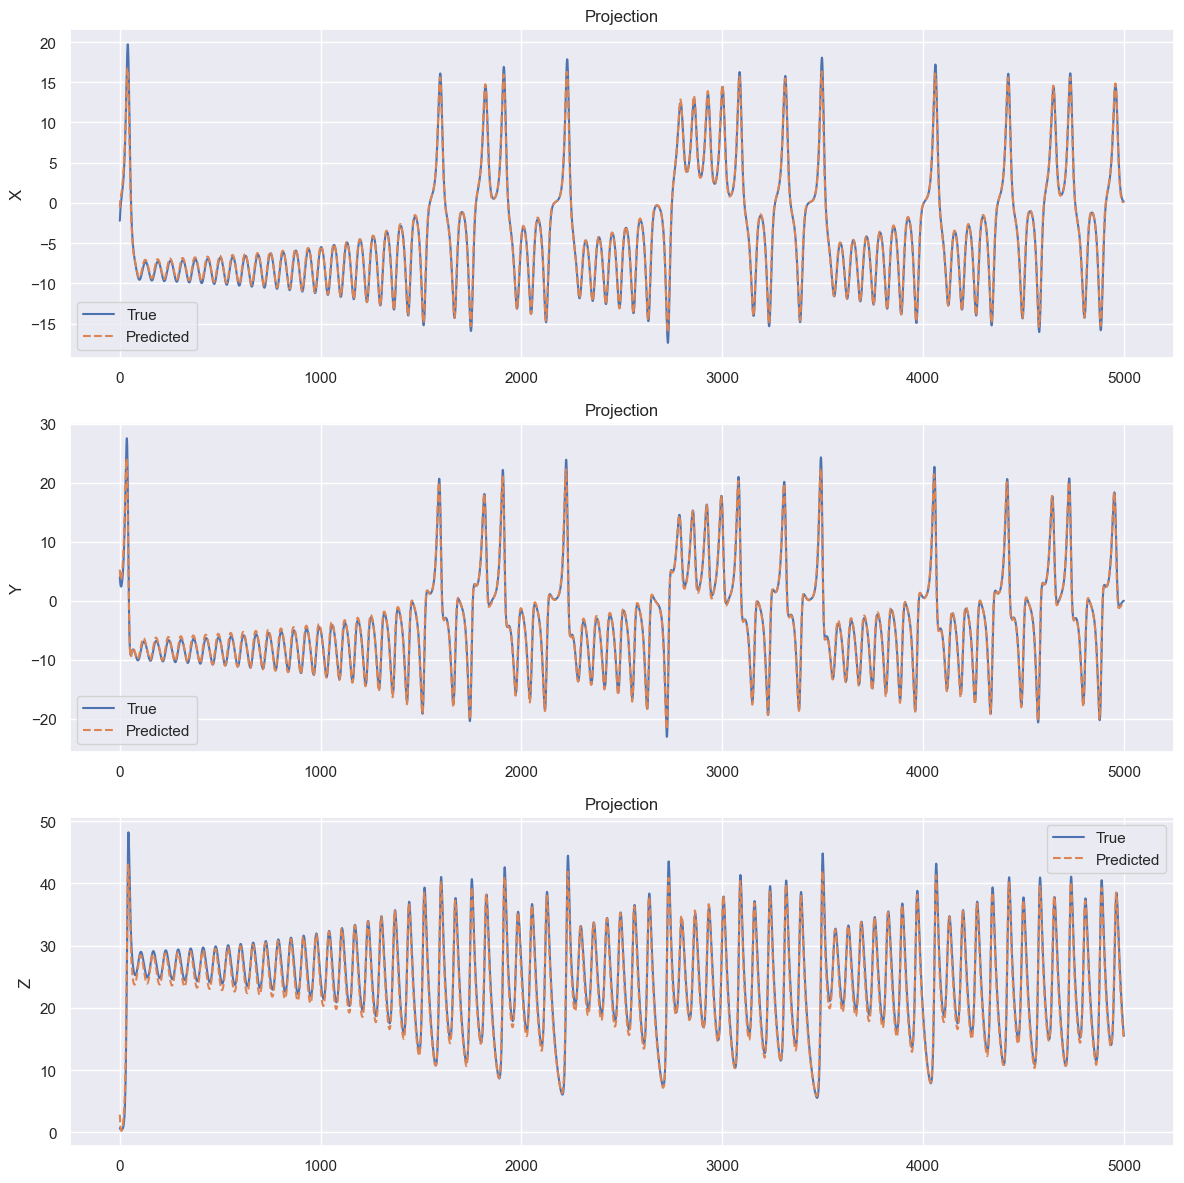

In [150]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred.view(4999,1), label='Predicted',linestyle='--')

ax[0].set_ylabel('X')
#ax[0].set_xlim(0, 1000)
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred.view(4999,1), label='Predicted',linestyle='--')
ax[1].set_ylabel('Y')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred.view(4999,1), label='Predicted',linestyle='--')
ax[2].set_ylabel('Z')
#ax[2].set_xlim(0, 400)
ax[2].set_title('Projection')
ax[2].legend()

plt.tight_layout()
plt.show()

In [153]:
for x, y in test_loader:
    print(x)
    break

tensor([[[-2.2064,  4.0314,  0.6872]]])


In [158]:
test[0][0].shape

torch.Size([1, 3])

In [159]:
input_seq = x[:, :1, :]

In [160]:
input_seq.shape

torch.Size([1, 1, 3])

In [163]:
predictions.shape

torch.Size([1, 24995, 3])

In [191]:
test_loader.dataset.tensors[1].shape

torch.Size([4999, 1, 3])

In [193]:
test_losses = []
predictions = []

with torch.no_grad():
    preds = []
    test_batch_loss = []

    for x, y in test_loader:
        # Get the initial input (first time step)
        input_seq = x[:, 0:1, :]
        break

    # Number of future time steps to predict
    num_steps = 4998 

    # Initial hidden and cell states for the LSTM
    h0 = torch.zeros(1, x.size(0), model.lstm.hidden_size).to(x.device)
    c0 = torch.zeros(1, x.size(0), model.lstm.hidden_size).to(x.device)

    for _ in range(num_steps):
        # Forward pass for the current time step
        out, (h0, c0) = model.lstm(input_seq, (h0, c0))
        predicted_lorenz = model.fc(out[:, -1, :])

        # Append the prediction for this time step to preds
        preds.append(predicted_lorenz)

        # Update the input_seq for the next time step (use the predicted value)
        input_seq = predicted_lorenz.unsqueeze(1)

        # Compute the loss for this time step
        loss = criterion(predicted_lorenz, test_loader.dataset.tensors[1][_, :, :])
        test_batch_loss.append(loss.item())

    # Stack all the predictions along the time axis
    predictions = torch.stack(preds, dim=1)

    # Compute the mean loss across all time steps
    test_losses.append(np.mean(test_batch_loss))


In [199]:
test_losses

[139.71229362155663]

In [194]:
predictions.shape

torch.Size([1, 4998, 3])

In [195]:
predictions = predictions.squeeze(0)

In [196]:
x_pred = predictions[:, 0]
y_pred = predictions[:,1]
z_pred = predictions[:,2]

In [197]:
x_pred.shape

torch.Size([4998])

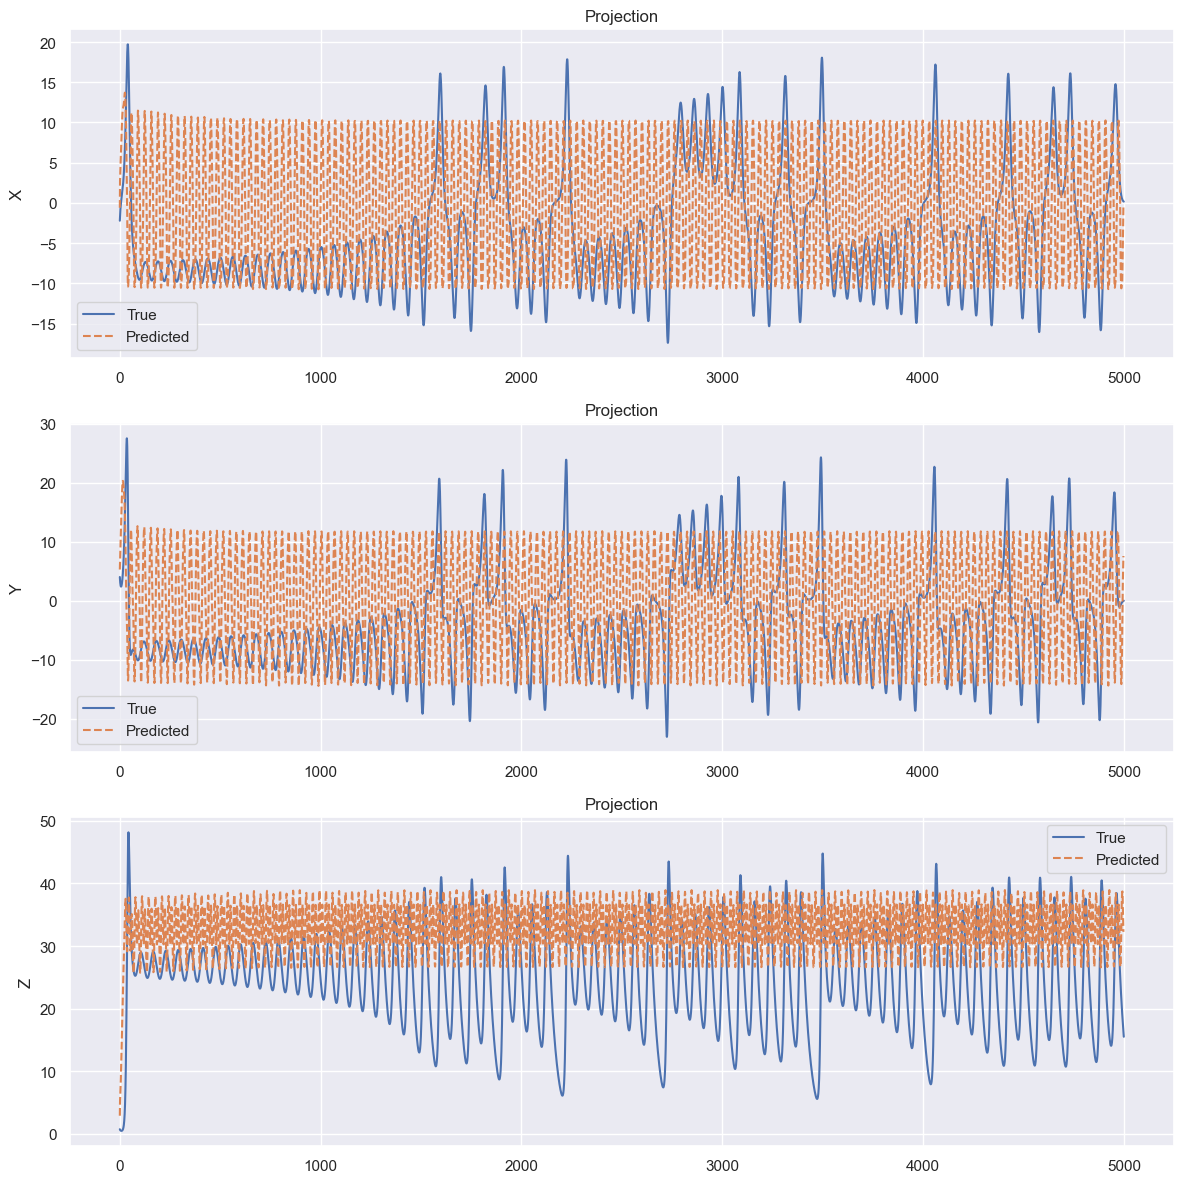

In [198]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')

ax[0].set_ylabel('X')
#ax[0].set_xlim(0, 1000)
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred, label='Predicted',linestyle='--')
ax[2].set_ylabel('Z')
#ax[2].set_xlim(0, 400)
ax[2].set_title('Projection')
ax[2].legend()

plt.tight_layout()
plt.show()